In [3751]:
import os
import csv
import math
import random
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor

from keras.models import Sequential
from keras.layers import Dense

KNOTS2KMH = 1.852  # knots to km/h
KMH2KNOTS = 0.539957  # km/h to knots
MINDISTWHEEL = 2 # KM : used for the straight line above the objective
# WARNING : Values are wrong, this is just a sketch

# FUEL_CONSUMPTION_RATE =  3 #2.5 # KG / KM for a 100 knots speed for X plane model
pd.reset_option('display.max_colwidth')


In [3752]:
# average_fuel_consumption 	= 0.302 # this is highly relative, but good estimates are 36-40l/min = 28-31kg/min = 0.47-0.52kg/s -- 45l/min = 35kg/min = 0.583kg/s
class Plane:
    def __init__(self, name: str = 'TF51D', fuel_consumption_rate: float = 0.52, fuel_max: int = 501, V_OPT: int = 240, V_max: int = 485):
        self.name = name
        self.fuel_consumption_rate = fuel_consumption_rate
        self.fuel_max = fuel_max
        self.V_OPT = V_OPT  # Optimal speed in knots
        self.V_max = V_max  # Max speed in knots
        self.V_Opt_kmh = self.V_OPT * KNOTS2KMH
        self.V_max_kmh = self.V_max * KNOTS2KMH
        self.max_flight_time = round(
            self.fuel_max / self.fuel_consumption_rate)
        print("Cet avion peut voler pendant ", self.max_flight_time,
              " s, soit ", round(self.max_flight_time / 60), " min à une vitesse moyenne de ", self.V_Opt_kmh, " km/h et sa vitesse max sera de ", self.V_max_kmh, " km/h")

    def __repr__(self):
        return self.name

    def __str__(self):
        return self.name

    def get_consumption_rate(self, speed: float) -> float:
        return self.fuel_consumption_rate * speed / self.V_Opt_kmh


class Maneuver:
    def __init__(self, name : str,fullname: str, meanspeed: int, altitude: float, distance: float, available_mission: list = ['CAS'], efficiency: int = 50):
        self.name = name
        self.fullname = fullname
        self.meanspeed = meanspeed  # In knots
        self.meanspeed_kmh = self.meanspeed * KNOTS2KMH
        self.altitude = altitude  # In KM
        self.distance = distance  # In KM
        self.available_mission = available_mission
        if efficiency <= 100 and efficiency >= 0:
            self.efficiency = efficiency
        else:
            self.efficiency = 0
            raise Exception("Efficiency is not valid, set to 0")
    
    def travelled_time(self) -> float:
        if self.name == 'Wheel':
            if self.distance <= 2 * MINDISTWHEEL:
                raise Exception("Not enough distance, at least ", MINDISTWHEEL, " km for a nicely done wheel")
            else :
                trueTime = MINDISTWHEEL / ((self.meanspeed_kmh * (3/2)) / 3600)
                trueTime += ((self.distance - MINDISTWHEEL)  / (self.meanspeed_kmh / 3600))
        else :
            trueTime = (self.distance / (self.meanspeed_kmh / 3600))  # In s
        return trueTime

        
    def fuel_consumption_rate(self, plane: Plane,) -> float:
        
        # Kg/s according to a plane's mean consumption rate, speed and altitude
        return ((plane.get_consumption_rate(self.meanspeed_kmh)) / (self.altitude**2 ))#* 3))

    def total_fuel_consumption(self, plane: Plane) -> float:
        # Kg according to the travelled time.
        return self.fuel_consumption_rate(plane) * self.travelled_time()

    def __repr__(self):
        return self.fullname

    def __str__(self):
        return self.fullname


In [3753]:

# Altitude is not concerned : fuel consumption rate is dependant on speed
list_maneuvers = [
    Maneuver('Wheel','FastFullWheel', 350, 1, 10, ['CAS', 'SCAR'], 100), 
    # Maneuver('FastQuarterWheel', 350, 1, 2, ['CAS', 'SCAR'], 50),
    Maneuver('Wheel','FastHalfWheel', 350, 1, 6, ['CAS', 'SCAR'], 75), 
    Maneuver('Wheel','NormalFullWheel', 240, 1, 10, ['CAS', 'SCAR'], 85),
    # Maneuver('NormalQuarterWheel', 240, 1, 2, ['CAS', 'SCAR'], 40), 
    Maneuver('Wheel','NormalHalfWheel', 240, 1, 6, ['CAS', 'SCAR'], 75),
    Maneuver('Wheel','FullLowWheel', 240, 0.5, 10, ['CAS', 'SCAR'], 75), 
    # Maneuver('QuarterLowWheel', 240, 0.5, 2, ['CAS', 'SCAR'], 30),
    Maneuver('Wheel','HalfLowWheel', 240, 0.5, 6, ['CAS', 'SCAR'], 50), 
    Maneuver('Wheel','LargeFullWheel', 350, 1, 14, ['CAS', 'SCAR'], 95),
    # Maneuver('NormalFullWheel',250, 1, 8, ['CAS', 'SCAR']), Maneuver('NormalQuarterWheel', 250, 1, 4, ['CAS', 'SCAR']),
    # Maneuver('NormalHalfWheel', 250, 1, 4, ['CAS', 'SCAR']), Maneuver('NormalLowFullWheel',250, 0.5, 8, ['CAS', 'SCAR']),
    # Maneuver('NormalLowQuarterWheel', 250, 0.5, 4, ['CAS', 'SCAR']), Maneuver('NormalLowHalfWheel', 250, 0.5, 4, ['CAS', 'SCAR']),
    Maneuver('Wheel','SlowFullWheel', 180, 1, 10, ['CAS', 'SCAR'], 65), 
    Maneuver('Wheel','SlowHalfWheel', 180, 1, 6, ['CAS', 'SCAR'], 50),
    # Maneuver('SlowQuarterWheel', 180, 1, 2, ['CAS', 'SCAR'], 25), 
    Maneuver('Wheel','SlowLowFullWheel', 180, 1, 10, ['CAS', 'SCAR'], 40),
    Maneuver('Wheel','SlowLowHalfWheel', 180, 1, 6, ['CAS', 'SCAR'], 30),
    # Maneuver('SlowLowQuarterWheel', 180, 1, 2, ['CAS', 'SCAR'], 20),
    Maneuver('Wheel','HighFullWheel', 240, 1.5, 10, ['CAS', 'SCAR'], 90),
    Maneuver('Wheel','HighHalfWheel', 240, 1.5, 6, ['CAS', 'SCAR'], 75),
    # Maneuver('HighQuarterWheel', 240, 1.5, 2, ['CAS', 'SCAR'], 50),
    Maneuver('ShowOfForce','ClassicShowOfForce',  500, 0.3, 10, ['SCAR'], 100),
]


In [3754]:
dic_maneuvers = dict()

for i in range(len(list_maneuvers)):
    dic_maneuvers[i] = list_maneuvers[i]


In [3755]:
print(dic_maneuvers)

{0: FastFullWheel, 1: FastHalfWheel, 2: NormalFullWheel, 3: NormalHalfWheel, 4: FullLowWheel, 5: HalfLowWheel, 6: LargeFullWheel, 7: SlowFullWheel, 8: SlowHalfWheel, 9: SlowLowFullWheel, 10: SlowLowHalfWheel, 11: HighFullWheel, 12: HighHalfWheel, 13: ClassicShowOfForce}


In [3756]:
TF51D = Plane()
M2000 = Plane('M2000', 2, 3200, 532, 2340 * KMH2KNOTS)
plane_list = [TF51D, M2000]


Cet avion peut voler pendant  963  s, soit  16  min à une vitesse moyenne de  444.48  km/h et sa vitesse max sera de  898.22  km/h
Cet avion peut voler pendant  1600  s, soit  27  min à une vitesse moyenne de  985.264  km/h et sa vitesse max sera de  2340.00085176  km/h


In [3757]:
print("Voila le coût en fuel des manoeuvres : ")
for plane in plane_list:
    print("Plane : ", plane)
    for man in list_maneuvers:
        print(man.fuel_consumption_rate(plane), " kg / s | ", man.total_fuel_consumption(plane),
              " kg for this maneuver | ", man.travelled_time(), " seconds for this maneuver, so ", math.floor(man.travelled_time() / 60), " min ", round(man.travelled_time() % 60, 2), " seconds")


Voila le coût en fuel des manoeuvres : 
Plane :  TF51D
0.7583333333333333  kg / s |  39.30885529157667  kg for this maneuver |  51.83585313174945  seconds for this maneuver, so  0  min  51.84  seconds
0.7583333333333333  kg / s |  22.462203023758097  kg for this maneuver |  29.620487503856832  seconds for this maneuver, so  0  min  29.62  seconds
0.52  kg / s |  39.30885529157667  kg for this maneuver |  75.59395248380129  seconds for this maneuver, so  1  min  15.59  seconds
0.52  kg / s |  22.4622030237581  kg for this maneuver |  43.196544276457885  seconds for this maneuver, so  0  min  43.2  seconds
2.08  kg / s |  157.23542116630668  kg for this maneuver |  75.59395248380129  seconds for this maneuver, so  1  min  15.59  seconds
2.08  kg / s |  89.8488120950324  kg for this maneuver |  43.196544276457885  seconds for this maneuver, so  0  min  43.2  seconds
0.7583333333333333  kg / s |  56.15550755939525  kg for this maneuver |  74.05121875964208  seconds for this maneuver, so  1

In [3758]:
import itertools


def get_all_combinations(d: dict) -> dict:
    keys, values = zip(*d.items())
    ret = [{'metadata': dict(zip(keys, v))}
           for v in itertools.product(*values)]
    return ret


param_list = {
    'Plane': plane_list,
    'GoalDistance': [0, 10, 15, 20, 30],
    'BingoDistance': [0, 10, 15, 20, 30],
    'Fuel': [ 300, 400, 400, 450, 500, 550],
    'MaxSpeedOP': [250, 300, 350, 400],
    'MeanSpeed': [100, 125, 150],
    # Start with just 2 states : good (sunny, no clouds) and bad (cloudy or rainy)
    'Meteo': ["Bad", "Good"],
    'MissionType': [ 'SCAR'], # 'CAS',
    'Strength': ['Weak', 'Equal', 'Strong'],  # Add ennemies number afterwards
    # '' : [90,0,50]
}

all_combinations_not_filtered = get_all_combinations(param_list)
all_combinations = []
for c in all_combinations_not_filtered:
    data = c['metadata']

    plane = data['Plane']
    if plane.name == 'M2000':
        data['Fuel'] *= 6
    # Check if the data corresponds to the plane caracteristics
    if plane.fuel_max >= data['Fuel'] and plane.V_max > data['MeanSpeed'] and plane.V_OPT >= data['MeanSpeed'] and plane.V_max >= data['MaxSpeedOP']:
        all_combinations.append(data)


In [3759]:
print(len(all_combinations))
print(len(all_combinations_not_filtered))


18000
21600


In [3760]:
for c in all_combinations:
    plane = c['Plane']
    fcr = plane.fuel_consumption_rate
    speed = c['MaxSpeedOP'] * KNOTS2KMH
    c['FuelRemaining'] = c['Fuel'] - (fcr * (c['GoalDistance'] / speed) * 3600) - (
        fcr * (c['BingoDistance'] / speed) * 3600)
    # c['BaseFuelRemaining'] = c['FuelRemaining']


In [3761]:
def choose_randomly(maneuvers_for_c, c) -> list:
    percent = math.ceil(random.random() * 100)
    # percent = math.ceil(random.gauss(50,(50-5)/3))
    if percent < 0:
        percent += 100
    elif percent > 100:
        percent -= 100
    max_speed = c['MaxSpeedOP']
    new_maneuvers = []
    new_maneuvers = filter(
        lambda m: dic_maneuvers[m].meanspeed <= max_speed, maneuvers_for_c)
    if c['Strength'] == 'Weak' or c['Strength'] == 'Equal':
        if percent <= 95:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].meanspeed >= 200, new_maneuvers)
        else:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].meanspeed < 200, new_maneuvers)
    elif c['Strength'] == 'Strong':
        if percent <= 95:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].meanspeed < 200, new_maneuvers)
        else:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].meanspeed >= 200, new_maneuvers)

    if c['Meteo'] == "Bad":
        if percent <= 95:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].altitude < 1, new_maneuvers)
        else:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].altitude >= 1, new_maneuvers)
    else:
        if percent <= 95:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].altitude >= 1, new_maneuvers)
        else:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].altitude < 1, new_maneuvers)
    return list(new_maneuvers)


In [3762]:
def select_maneuvers(maneuvers_for_c, c):
    selected = []
    minCost = min(dic_maneuvers[man].total_fuel_consumption(
        c['Plane']) for man in maneuvers_for_c)
    minEfficiency = min(
        dic_maneuvers[man].efficiency for man in maneuvers_for_c)
    efficiency = 90
    # and len(selected) < 4:
    # print(c['FuelRemaining'])
    while c['FuelRemaining'] >= minCost and efficiency >= minEfficiency and len(selected) < 5:
        maneuvers_with_eff = list(filter(
            lambda man: dic_maneuvers[man].efficiency >= efficiency, maneuvers_for_c))
        if len(maneuvers_with_eff) != 0:
            rand = random.randint(0, len(maneuvers_with_eff)-1)
            man = dic_maneuvers[maneuvers_with_eff[rand]]
            if (c['FuelRemaining'] - man.total_fuel_consumption(c['Plane'])) >= 0:
                c['FuelRemaining'] -= man.total_fuel_consumption(c['Plane'])
                selected.append(maneuvers_with_eff[rand])
            else:
                efficiency -= 5
        else:
            efficiency -= 5
    return selected


In [3763]:
indexed_maneuvers = list_maneuvers.copy()

p = True
combinations = all_combinations.copy()
count = 0
all_maneuvers_for_c = []
for c in combinations:
    maneuvers_for_c = list(filter(
        lambda m: c['MissionType'] in dic_maneuvers[m].available_mission, dic_maneuvers))
    maneuvers_for_c = list(filter(lambda m: dic_maneuvers[m].total_fuel_consumption(
        c['Plane']) < c['FuelRemaining'], maneuvers_for_c))
    maneuvers_for_c = choose_randomly(maneuvers_for_c, c)
    all_maneuvers_for_c.append(maneuvers_for_c)



In [3764]:
final_combinations = combinations.copy()
for c, maneuvers_for_c in zip(final_combinations, all_maneuvers_for_c):
    if len(maneuvers_for_c) > 0 :
        maneuvers = select_maneuvers(maneuvers_for_c, c)
        if maneuvers != None or len(maneuvers) > 0:
            c['Maneuvers'] = list(maneuvers)
            c['TimeOfMission'] = sum(
                dic_maneuvers[m].travelled_time() for m in c['Maneuvers'])


In [3765]:
# print(impossible_combinations)
final_combinations_plane = [
    c for c in final_combinations if c.get("Maneuvers")]
# print(len(final_combinations), len(final_combinations_plane))
# for c in final_combinations_plane:
#     # c['Maneuvers'] = [c.__dict__ for c in c['Maneuvers']]
#     # c['Plane'] = c['Plane']

final_combinations_maneuvers = final_combinations_plane.copy()
# final_combinations_maneuvers = final_combinations.copy()
list_maneuvers = []

for c in final_combinations_maneuvers:
    list_maneuvers.append(c['Maneuvers'])

print(len(list_maneuvers))
first_tuple_list = []
for lst in list_maneuvers:
    first_tuple_list.append(tuple(lst))
print("Done")
set_man = set(first_tuple_list)
new_dict = dict()

for i in range(len(set_man)):
    new_dict[set_man.pop()] = i
print(len(new_dict))


14797
Done
315


In [3766]:
# print(dic_maneuvers.get(i))

for c in final_combinations_maneuvers:
    c['Maneuvers'] = new_dict.get(tuple(c['Maneuvers']))
df = pd.DataFrame(final_combinations_maneuvers)


In [3767]:

df.sample(10)


,Plane,GoalDistance,BingoDistance,Fuel,MaxSpeedOP,MeanSpeed,Meteo,MissionType,Strength,FuelRemaining,Maneuvers,TimeOfMission
2039,TF51D,10,10,500,350,125,Good,SCAR,Weak,233.840721,123,327.368096
2986,TF51D,15,0,300,350,150,Bad,SCAR,Weak,60.135761,263,503.959683
5130,TF51D,20,15,400,350,150,Bad,SCAR,Equal,51.835853,15,118.790497
10665,M2000,15,10,1800,250,125,Good,SCAR,Weak,1259.664279,174,377.969762
4555,TF51D,20,0,400,250,100,Bad,SCAR,Weak,4.665227,149,151.187905
7969,M2000,0,10,3000,350,150,Good,SCAR,Weak,2489.436334,51,303.609997
3908,TF51D,15,20,400,250,125,Bad,SCAR,Weak,11.403888,15,118.790497
13339,M2000,30,0,1800,300,100,Good,SCAR,Strong,1070.205752,263,503.959683
3312,TF51D,15,10,400,250,125,Bad,SCAR,Equal,51.835853,15,118.790497
13884,M2000,30,10,3000,350,125,Bad,SCAR,Equal,1191.591289,211,377.969762


In [3768]:

df.describe()


,GoalDistance,BingoDistance,Fuel,MaxSpeedOP,MeanSpeed,FuelRemaining,Maneuvers,TimeOfMission
count,14797.000000,14797.000000,14797.000000,14797.000000,14797.000000,14797.000000,14797.000000,14797.000000
mean,14.997973,14.971954,1436.034331,324.974657,124.976347,756.190955,195.368115,343.743504
std,9.988334,9.994130,1063.954394,55.938330,20.399981,799.314346,71.986352,125.902718
min,0.000000,0.000000,300.000000,250.000000,100.000000,0.129590,0.000000,43.196544
25%,10.000000,10.000000,400.000000,250.000000,100.000000,91.727862,173.000000,306.695464
50%,15.000000,15.000000,1800.000000,300.000000,125.000000,264.411569,211.000000,377.969762
75%,20.000000,20.000000,2400.000000,400.000000,150.000000,1436.944413,263.000000,377.969762
max,30.000000,30.000000,3000.000000,400.000000,150.000000,2848.433178,314.000000,503.959683


In [3769]:
pd.set_option('display.max_colwidth', None)
df.sample(1).get("Maneuvers")
pd.reset_option('display.max_colwidth')


In [3770]:


df = pd.get_dummies(df, columns=["Plane", "Meteo", "MissionType", "Strength"])
df.sample(10)
# data_MissionType = pd.DataFrame(ohe.fit_transform(data_meteo[["MissionType"]]))
# data_Strength = pd.DataFrame(ohe.fit_transform(data_MissionType[["Strength"]]))
# data_Strength


,GoalDistance,BingoDistance,Fuel,MaxSpeedOP,MeanSpeed,FuelRemaining,Maneuvers,TimeOfMission,Plane_TF51D,Plane_M2000,Meteo_Bad,Meteo_Good,MissionType_SCAR,Strength_Equal,Strength_Strong,Strength_Weak
10306,10,30,3000,250,125,2226.402940,174,377.969762,0,1,0,1,1,0,0,1
9252,10,10,2400,300,125,776.719336,211,377.969762,0,1,1,0,1,0,0,1
7743,0,10,1800,400,125,1361.782426,263,503.959683,0,1,0,1,1,0,1,0
2296,10,15,450,400,125,178.425726,112,327.368096,1,0,0,1,1,1,0,0
8817,0,30,3000,250,100,2192.451972,263,503.959683,0,1,0,1,1,0,1,0
7324,30,30,450,400,125,94.972402,193,373.341561,1,0,0,1,1,0,0,1
695,0,15,400,400,125,120.002400,160,371.798828,1,0,0,1,1,1,0,0
11498,15,20,3000,300,125,2205.410936,263,503.959683,0,1,1,0,1,1,0,0
3370,15,10,400,250,125,102.375810,263,503.959683,1,0,1,0,1,1,0,0
5028,20,10,500,400,150,215.790737,122,327.368096,1,0,0,1,1,0,0,1


In [3771]:
df_first = df.copy()
X_train, X_test, y_train, y_test = train_test_split(df_first.drop(
    "TimeOfMission", axis=1), df_first["TimeOfMission"], test_size=0.15)
# X_train, X_test, y_train, y_test = train_test_split( df.drop("Maneuvers", axis=1), df["Maneuvers"], test_size=0.30)
models = [Lasso(), KNeighborsRegressor(), RandomForestRegressor(),
          GradientBoostingRegressor()]

once = False
for model in models:

    # Model is trained with the corrupted / imputed data
    model.fit(X_train, y_train)

    # Model performance is evaluated against the original test dataset
    y_pred = model.predict(X_test)
    # y_pred = [round(y) for y in y_pred]
    score = r2_score(y_test, y_pred)
    if not once:
        for t, p in zip(y_test, y_pred):
            print(t, p)
        once = True
    print(model, score)


377.96976241900643 315.63498882022833
503.959683225342 545.564177490188
327.36809626658436 394.7585872838053
503.959683225342 526.159343583751
377.96976241900643 344.5817383383705
377.96976241900643 347.73989459412996
151.18790496760258 191.580414361079
305.1527306386917 388.08660953882946
377.96976241900643 350.49213010962717
303.60999691453253 365.780753345416
377.96976241900643 371.131666589343
328.9108299907436 346.24118348142633
306.69546436285094 362.3514440053052
503.959683225342 529.8607396044764
503.959683225342 531.4814278227257
503.959683225342 471.96479888831004
377.96976241900643 370.7911768653656
377.96976241900643 389.2528757852355
503.959683225342 501.8523041911137
503.959683225342 493.3696497720392
327.36809626658436 331.09428269164056
374.884294970688 366.95875223352
75.59395248380129 185.63224604297673
118.79049676025917 150.2223741633656
373.34156124652884 317.2056975617328
377.96976241900643 372.0128813777923
377.96976241900643 359.50247291865134
351.1261956186362 

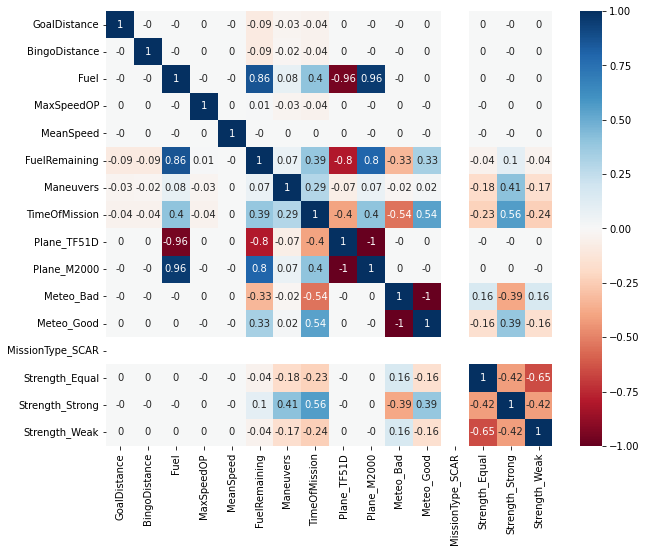

In [3772]:
matrice_corr = df_first.corr().round(2)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=matrice_corr, cmap='RdBu', annot=True)

plt.show()


In [3773]:

df_second = df.copy()
# , df_second["Maneuvers"],]
X_train, X_test, y_train, y_test = train_test_split(df_second.drop(
    ["TimeOfMission", "Maneuvers", "FuelRemaining"], axis=1), df_second["Maneuvers"], test_size=0.30)
# X_train, X_test, y_train, y_test = train_test_split( df.drop("Maneuvers", axis=1), df["Maneuvers"], test_size=0.30)
models = [Lasso(), KNeighborsRegressor(), RandomForestRegressor(
    n_estimators=100), GradientBoostingRegressor(), DecisionTreeRegressor(max_depth=5)]

print(X_train.columns)


Index(['GoalDistance', 'BingoDistance', 'Fuel', 'MaxSpeedOP', 'MeanSpeed',
       'Plane_TF51D', 'Plane_M2000', 'Meteo_Bad', 'Meteo_Good',
       'MissionType_SCAR', 'Strength_Equal', 'Strength_Strong',
       'Strength_Weak'],
      dtype='object')


In [3774]:

for model in models:
    # Model is trained with the corrupted / imputed data
    model.fit(X_train, y_train)

once = False
dim = X_train.shape[1]
epochs = 50
activation_names = ["relu", "sigmoid", "tanh"]
# for activation in activation_names :
#     model = Sequential()
#     #On pourrait essayer de rajouter plusieurs paramètres de modèles différents notamment en rajoutant des couches supplémentaires ou en utilisant un nombre de neurones cachés différent. Nous allons nous contenter ici de seulement changer la fonction d'activation.
#     model.add(Dense(150, input_dim= dim, activation=activation))
#     #On peut essayer d'ajouter une couche intermédiaire, mais la performance ne sera pas assez intéressante
#     #model.add(Dense(300, activation=name))
#     model.add(Dense(150, activation=activation))

#     # Vu que l'on utilise une régression pour un prix, on utilise une fonction d'activation linéaire pour la sortie
#     model.add(Dense(1, activation='linear'))
#     model.compile(loss='mean_squared_error', optimizer='adam')

#     #visualize_model(X_train, X_test, y_train, y_test, model, show_pred_vs_y_test=True)
#     model.fit(X_train, y_train,epochs=epochs, verbose = 0)

#     models.append(model)
scores = []
for model in models:

    # Model performance is evaluated against the original test dataset
    y_pred = model.predict(X_test)
    # y_pred = [round(y) for y in y_pred]
    scores.append(r2_score(y_test, y_pred))
    if not once:
        for t, p, x in zip(y_test, y_pred, X_test.values):
            print(t, p, x)
        once = True


174 180.7844131108016 [  15   15 2400  250  125    0    1    0    1    1    1    0    0]
292 180.5582609067904 [  0  30 300 400 125   1   0   1   0   1   1   0   0]
6 160.1331218055737 [ 30  20 400 400 125   1   0   0   1   1   1   0   0]
15 183.24611116934653 [ 20  30 450 300 125   1   0   1   0   1   1   0   0]
271 181.09467181646517 [ 20  15 500 400 150   1   0   1   0   1   1   0   0]
174 170.73510181649957 [ 20   0 400 250 125   1   0   0   1   1   0   0   1]
292 179.23304746761178 [ 30  10 300 400 150   1   0   1   0   1   1   0   0]
174 167.31276823467985 [ 15  15 400 300 125   1   0   0   1   1   1   0   0]
174 181.009085021711 [  10    0 2400  300  125    0    1    0    1    1    1    0    0]
149 182.4482451138563 [ 15   0 400 400 100   1   0   1   0   1   1   0   0]
211 197.68197916206867 [  30   20 3000  300  150    0    1    1    0    1    1    0    0]
31 168.87197498846928 [  30   15 1800  400  150    0    1    0    1    1    1    0    0]
211 197.94514270857778 [  10   10 

In [3775]:
for model, score in zip(models, scores):
    print(model, score)


Lasso() 0.20301435835254356
KNeighborsRegressor() -0.04027378148530314
RandomForestRegressor() 0.2671031026898635
GradientBoostingRegressor() 0.2873413675262665
DecisionTreeRegressor(max_depth=5) 0.26422358272047564


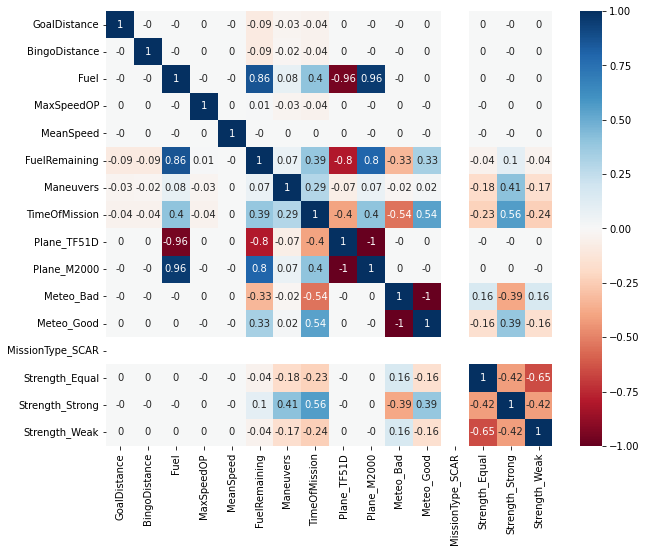

In [3776]:

matrice_corr = df_second.corr().round(2)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=matrice_corr, cmap='RdBu', annot=True)

plt.show()


In [3777]:
# Export as dot file
# export_graphviz(models[4], out_file='tree.dot',
#                 feature_names=df_second.drop(
#                     ["TimeOfMission", "FuelRemaining", "Maneuvers"], axis=1).columns,
#                 class_names="TimeOfMission",
#                 rounded=True, proportion=False,
#                 precision=6, filled=True)
# os.system('dot -Tpng tree.dot -o tree.png')
# Display in jupyter notebook


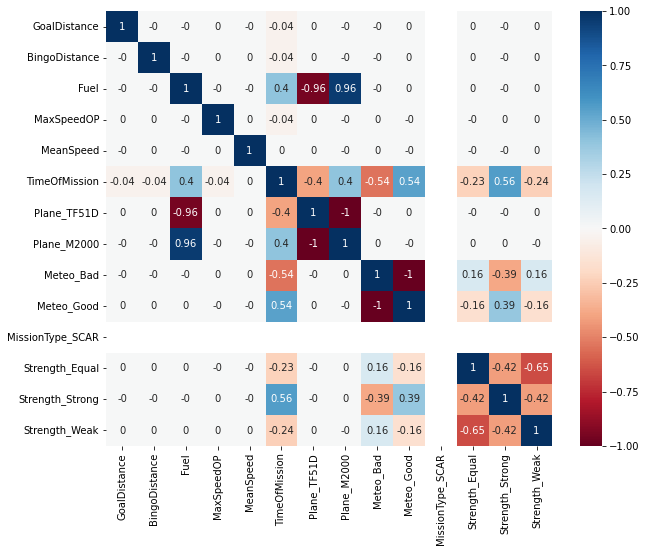

In [3778]:

matrice_corr = df_second.drop(
    ["Maneuvers", "FuelRemaining"], axis=1).corr().round(2)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=matrice_corr, cmap='RdBu', annot=True)

plt.show()
